In [72]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from nltk import sent_tokenize, word_tokenize
from textblob import TextBlob
from transformers import BertTokenizer
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [73]:
file_path = "/content/Dune_ Part Two (2024)- IMDb.html"
with open(file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()
soup = BeautifulSoup(html_content, 'html.parser')

In [74]:
html = soup.find_all('div', {"class":"review-container"})
print(len(html))

1725


In [75]:
first_review = html[0]
first_review.a.text


' Long live the fighters\n'

In [76]:
reviews = []

for row in html:
  # review = row.find_all("div", {"class" : "text show-more__control"})
  review = row.a.text
  reviews.append(review)

reviews

[' Long live the fighters\n',
 ' This is what Hollywood needs!\n',
 ' Ladies and gentleman.. the PEAK of filmmaking!!\n',
 " Arrakis is Real. Believe Me I've Seen It.\n",
 ' Visual masterpiece, questionable narrative\n',
 ' The Sci-Fi/Fantasy Epic of our Generation\n',
 ' WOW! I need Dune Messiah now.\n',
 ' Paul Atreides is handled masterfully\n',
 ' A masterpiece, a pillar of sci-fi/fantasy\n',
 ' RIDICULOUS\n',
 ' One Of The Greatest Sequel Ever Made, Dune: Part Two Was Easily The Best Films Of The Year So Far\n',
 " A movie of epic proportions, everything I'd hoped for.\n",
 ' Beautiful production, less than perfect script\n',
 ' Hard to put into words\n',
 ' The Dark Knight and Empire Strikes Back of our generation...\n',
 ' Incredible Film\n',
 ' Denis Villeneuve is a modern sorcerer in Sci-Fi!\n',
 ' Spectacle\n',
 ' A Masterpiece\n',
 ' Absolutely stunning\n',
 ' I wish it was better\n',
 " Am I the only one who's not seeing it?\n",
 ' Enjoyed it, but not blown away\n',
 ' A Sp

In [77]:
df = pd.DataFrame({'Review' : reviews})
df.to_csv('IMDB_Reviews_Dune.csv', index=False)

In [78]:
data = pd.read_csv('IMDB_Reviews_Dune.csv')
data

,Review
0,Long live the fighters\n
1,This is what Hollywood needs!\n
2,Ladies and gentleman.. the PEAK of filmmaking...
3,Arrakis is Real. Believe Me I've Seen It.\n
4,"Visual masterpiece, questionable narrative\n"
...,...
1720,Are you serious?! 10/10?! You are kidding...\n
1721,Over rated\n
1722,amazing graphics and special effects but movi...
1723,"""star wars is the best science-fiction and sa..."


In [79]:
data.loc[:, 'Review'] = data['Review'].str.replace('\n', '')

In [80]:
data.head()

,Review
0,Long live the fighters
1,This is what Hollywood needs!
2,Ladies and gentleman.. the PEAK of filmmaking!!
3,Arrakis is Real. Believe Me I've Seen It.
4,"Visual masterpiece, questionable narrative"


In [81]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [88]:
def preprocess_data(data):
    # Case Folding
    data['Review'] = data['Review'].str.lower()

    # Remove Number & Punctuation
    data['Review'] = data['Review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    data['Review'] = data['Review'].apply(lambda x: re.sub(r'\d+', '', x))

    # Stopword Removal
    stop_words = set(stopwords.words('english'))
    data['Review'] = data['Review'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

    # Tokenizing (BERT-Tokenizer)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    data['Tokenized'] = data['Review'].apply(lambda x: tokenizer.tokenize(x))

    return data

data = preprocess_data(data)

In [89]:
data

,Review,Sentiment,Tokenized
0,long live fighters,Positive,"[long, live, fighters]"
1,hollywood needs,Neutral,"[hollywood, needs]"
2,ladies gentleman peak filmmaking,Neutral,"[ladies, gentleman, peak, filmmaking]"
3,arrakis real believe ive seen,Positive,"[ar, ##rak, ##is, real, believe, iv, ##e, seen]"
4,visual masterpiece questionable narrative,Negative,"[visual, masterpiece, questionable, narrative]"
...,...,...,...
1720,serious kidding,Negative,"[serious, kidding]"
1721,rated,Neutral,[rated]
1722,amazing graphics special effects movie extreme...,Positive,"[amazing, graphics, special, effects, movie, e..."
1723,star wars best sciencefiction saga time silence,Positive,"[star, wars, best, science, ##fi, ##ction, sag..."


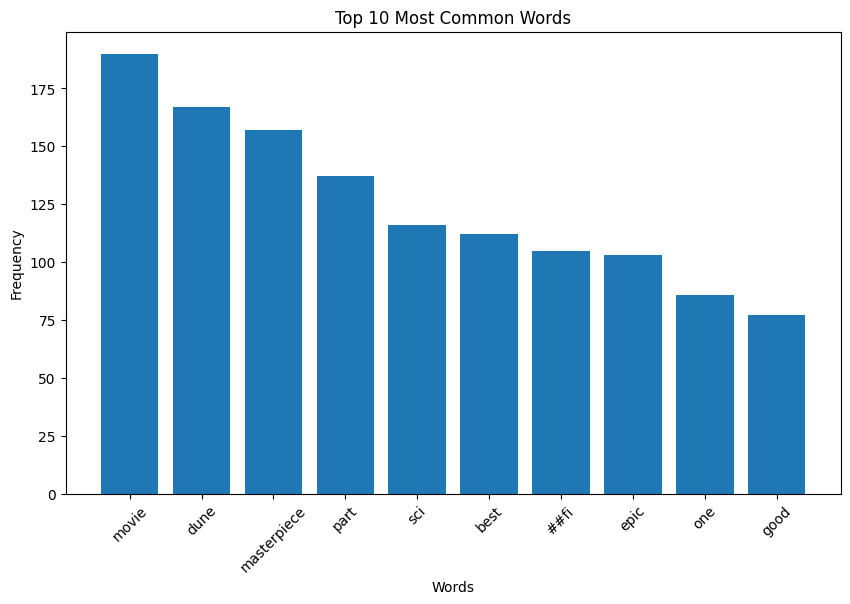

In [90]:
word_freq = Counter([word for sublist in data['Tokenized'] for word in sublist])

top_words = word_freq.most_common(10)
top_words = dict(top_words)

plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

In [91]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'Positive'
    elif sentiment < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment'] = data['Review'].apply(analyze_sentiment)

In [92]:
data

,Review,Sentiment,Tokenized
0,long live fighters,Positive,"[long, live, fighters]"
1,hollywood needs,Neutral,"[hollywood, needs]"
2,ladies gentleman peak filmmaking,Neutral,"[ladies, gentleman, peak, filmmaking]"
3,arrakis real believe ive seen,Positive,"[ar, ##rak, ##is, real, believe, iv, ##e, seen]"
4,visual masterpiece questionable narrative,Negative,"[visual, masterpiece, questionable, narrative]"
...,...,...,...
1720,serious kidding,Negative,"[serious, kidding]"
1721,rated,Neutral,[rated]
1722,amazing graphics special effects movie extreme...,Positive,"[amazing, graphics, special, effects, movie, e..."
1723,star wars best sciencefiction saga time silence,Positive,"[star, wars, best, science, ##fi, ##ction, sag..."


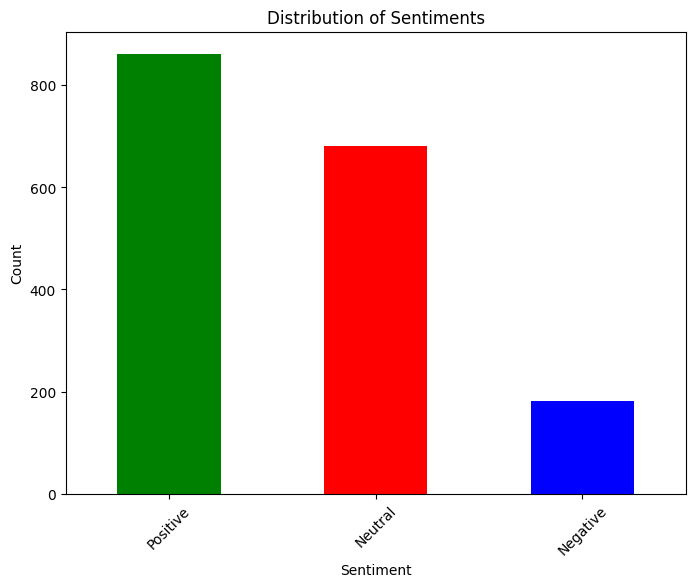

In [93]:
sentiment_counts = data['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [94]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X = data['Tokenized'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

X = pad_sequences(X)
y = data['Sentiment']
y_numeric = y.map({'Positive': 0, 'Negative': 1, 'Neutral': 2})

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

In [96]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.vocab), output_dim=64))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluating the model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4880 - loss: 1.0272 - val_accuracy: 0.5435 - val_loss: 0.9326
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5305 - loss: 0.9253 - val_accuracy: 0.7029 - val_loss: 0.8510
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7181 - loss: 0.7596 - val_accuracy: 0.7609 - val_loss: 0.6635
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8193 - loss: 0.4922 - val_accuracy: 0.7681 - val_loss: 0.5798
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8542 - loss: 0.3688 - val_accuracy: 0.7899 - val_loss: 0.5914
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9177 - loss: 0.2339 - val_accuracy: 0.8188 - val_loss: 0.4728
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9716 - loss: 0.1463 - val_accuracy: 0.8261 - val_loss: 0.4745
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9824 - loss: 0.0892 - val_accuracy: 0.8261 - v

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

    Negative       0.91      0.92      0.92       176
     Neutral       0.48      0.41      0.44        37
    Positive       0.83      0.86      0.84       132

    accuracy                           0.84       345
   macro avg       0.74      0.73      0.73       345
weighted avg       0.83      0.84      0.84       345



In [97]:
MAX_TOKEN_LEN = 256
def preprocess_text(text, tokenizer, max_token_len):
    tokens = tokenizer.encode(text, max_length=max_token_len, truncation=True)
    return np.array(tokens, dtype='int32').reshape(1, -1)

def predict(text):
    text_tokens = preprocess_text(text, tokenizer, MAX_TOKEN_LEN)

    y_pred_prob = model.predict(text_tokens)
    y_pred = np.argmax(y_pred_prob, axis=1)[0]

    labels_reverse = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment_label = labels_reverse[y_pred]

    return sentiment_label

In [98]:
text = "amazing graphics special effects movie"
predicted_sentiment = predict(text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Predicted Sentiment: Negative


In [99]:
text = "visual masterpiece questionable narrative"
predicted_sentiment = predict(text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Sentiment: Neutral
